In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import os
import numpy as np
import seaborn as sns

import matplotlib.style as style
import matplotlib.cm as cm
# style.use('seaborn-v0_8-poster')  # or 'default' (style.available to list styles)
style.use('default')

# Change the default math mode font to normal
plt.rcParams['mathtext.default'] = 'regular'

# Explore regressions between grab sample chemistry data and continuous data

Aims:
* Read in cleaned water chemistry data (all 3 rivers), river discharge data (all 3 rivers) and NIVA sensor data (Glomma only)
* For all three rivers, look for regressions between water chemistry data and river discharge. Potentially try seasonal regressions too (e.g. might expect different relationships in spring snow melt than during autumn)
* For Glomma, look for regressions between water chemistry data and sensor data. Hope to find relationships between SPM and turbidity, between FDOM and DOC (and lab CDOM data if we have it). Might find some relationships between e.g. conductivity and NOx, so just a general screening is a good idea too.

**N.B. Leah has done this a few times before in other places so has lots of code that can be reused.**

# User input

**UPDATE**

In [1]:
# Folders for storing output
ts_folder = r"../figures/timeseries/chem_and_qsim"
daily_chem_folder = r"../figures/timeseries/daily_chem"
flux_figure_folder = r"../figures/timeseries/fluxes"

# Useful stuff for the rest of the NB

In [3]:
chem_units_dict = {
    "SPM": r"$mg\;l^{-1}$",
    "DOC": r"$mg\;l^{-1}$",
    "TDN": r"$\mu g \; l^{-1}$",
    "NOx-N": r"$\mu g \; l^{-1}$",
    "NH4-N": r"$\mu g \; l^{-1}$",
    "SiO2": r"$\mu g \; l^{-1}$",
    "DON": r"$\mu g \; l^{-1}$"
}

# Read in data

## Chem data

In [4]:
infile = r'../data/water_chem/Svalbard_NIVA_riverchem_bestguess_2023-10-23.xlsx'
chem_df = pd.read_excel(infile, index_col=2, parse_dates=True)
chem_df.sort_index(inplace=True)
chem_df.head()

,Project,Labware,Site,Sampling_time,Sensor_pH,Sensor_Cond_µs/cm2,Sensor_Temp,Turb_sensor_handheld,SPM_mgL,TOC_mgL,DOC_mgL,TN_ugL,TDN_ugL,NOx-N_ugL,NH4-N_ugL,SiO2_ugL,Cl_mgL,SO4_mg_L,d2H-H2O,d18O-H2O
Date,,,,,,,,,,,,,,,,,,,,
2016-06-09,KlimaInfra,NR-2016-03495,Adventelva,NaN,7.42,25.60,NaN,NaN,95.3,1.2,NaN,170.0,NaN,70.0,9.0,3270.0,NaN,NaN,NaN,NaN
2016-07-14,KlimaInfra,NR-2016-05198,Adventelva,NaN,6.91,9.09,NaN,NaN,NaN,16.7,0.88,305.0,NaN,75.0,38.0,NaN,NaN,NaN,NaN,NaN
2016-08-18,KlimaInfra,NR-2016-06422,deGeerelva,13:10:00,6.66,86.50,NaN,4000.0,3157.6,47.5,0.35,470.0,NaN,160.0,124.0,NaN,NaN,NaN,NaN,NaN
2016-08-18,KlimaInfra,NR-2016-06423,Sassenelva,14:30:00,8.15,26.10,NaN,1900.0,3579.6,21.9,0.66,275.0,NaN,96.0,62.0,NaN,NaN,NaN,NaN,NaN
2016-08-19,KlimaInfra,NR-2016-06424,Gipsdalselva,11:00:00,8.09,34.50,NaN,500.0,590.8,2.2,0.54,225.0,NaN,141.0,11.0,3340.0,NaN,NaN,NaN,NaN


## Read in sensor data

In [9]:
sensor_df = pd.read_excel(
    r"../data/sensors/adventelva_sensor_data_niva_2017-2022_6am_mean.xlsx",
    index_col=0,
    parse_dates=True,
)

# Drop Vannstand and 1/Kon
sensor_df = sensor_df[['Konduktivitet', 'pH', 'Temperatur', 'S_norm', 'Turbiditet']]

sensor_rename_dict = {
    "Konduktivitet": "Conductivity",
    "Temperatur": "Water Temp",
    "S_norm": "Stage_norm",
    "pH": "pH",
    "Turbiditet": "Turbidity",
}

sensor_df = sensor_df.rename(columns=sensor_rename_dict)

sensor_df

,Conductivity,pH,Water Temp,Stage_norm,Turbidity
2017-06-28,NaN,NaN,4.765,NaN,NaN
2017-06-29,204.919,7.122,3.996,NaN,NaN
2017-07-02,277.031,7.204,5.270,NaN,NaN
2017-07-06,180.043,7.082,6.069,NaN,NaN
2017-07-07,194.971,7.189,4.878,NaN,NaN
...,...,...,...,...,...
2022-10-01,630.694,7.590,1.002,NaN,34.962
2022-10-02,668.034,7.610,1.060,NaN,12.840
2022-10-03,694.667,7.634,1.224,NaN,9.530
2022-10-04,NaN,7.678,0.188,NaN,9.242


## Q data

In [10]:
directory = r'../data/model_output/Adventelva_Q'

series_li = []

for fname in os.listdir(directory):
    if fname.endswith(".csv"):
        # read the csv file and convert it to a series
        file_path = os.path.join(directory, fname)
        series = pd.read_csv(file_path, index_col=0, parse_dates=True, sep=';').squeeze("columns")

        # rename the series using the filename
        name = fname.split('_')[1]
        series.name = name
        series_li.append(series)

# concatenate all series into a single dataframe & drop unwanted cols
q_df = pd.concat(series_li, axis=1)
drop_params = ['Stage2022', 'Stage2018']
q_df = q_df[q_df.columns.difference(drop_params)]

q_df = q_df.round(4)
q_df.head()

,Cond,DG4full,DG6full,DG6late,DG8full
,,,,,
1991-01-01,0.0,0.0,0.0,0.0,0.0
1991-01-02,0.0,0.0,0.0,0.0,0.0
1991-01-03,0.0,0.0,0.0,0.0,0.0
1991-01-04,0.0,0.0,0.0,0.0,0.0
1991-01-05,0.0,0.0,0.0,0.0,0.0


## Join sensor & Q data to make one dataframe of continuous data

This makes x_df, which is our main dataframe of potential explanatory variables.

N.B. though continuous, there may be data gaps

In [14]:
# Joing sensor data and simulated Q data into one df.
# After looking at the regressions, parameter set Q_DG6late tended to have tiddly bit better R2
# values than the other Q parameters, and almost nothing in it, so just pick that one

x_df = q_df.add_prefix('Q_').join(sensor_df, how='outer')
x_df = x_df.drop(columns=['Q_Cond', 'Q_DG4full', 'Q_DG6full', 'Q_DG8full'])

x_df.head()

,Q_DG6late,Conductivity,pH,Water Temp,Stage_norm,Turbidity
1991-01-01,0.0,NaN,NaN,NaN,NaN,NaN
1991-01-02,0.0,NaN,NaN,NaN,NaN,NaN
1991-01-03,0.0,NaN,NaN,NaN,NaN,NaN
1991-01-04,0.0,NaN,NaN,NaN,NaN,NaN
1991-01-05,0.0,NaN,NaN,NaN,NaN,NaN


# Plot time series

As a first screen for whether we may find relationships.

## Chem and Q

**This example is over-complicated as it plots lots of simulated Q series**

In [ ]:
def plot_q_chem_ts(q_df, chem_df, chem_vars, year_start, save_folder, y_label=None, fname=None):
    """
    Plot chem & q data on one time series plot
    """

    year_start = str(year_start)

    q_df_tmp = q_df.loc['%s-04-15' % year_start: '%s-10' % year_start]
    chem_df_tmp = chem_df.loc[year_start]

    # Calculate min and max values
    df_min = q_df_tmp.min(axis=1)
    df_max = q_df_tmp.max(axis=1)

    # Create a figure and subplot
    fig, ax = plt.subplots(figsize=(17, 8))

    # Plot all columns
    q_colour_dict = {
        0: "c",
        1: "darkturquoise",
        2: "steelblue",
        3: "cornflowerblue",
        4: "deepskyblue",
        5: "dodgerblue",
        6: "darkturquoise",
        7: "lightsteelblue",
    }
    for i, column in enumerate(q_df.columns):
        ax.plot(q_df_tmp.index, q_df_tmp[column], label='Q%s' % (i+1), color=q_colour_dict[i])

    # Fill between max and min
    ax.fill_between(q_df_tmp.index, df_min, df_max, color="gray", alpha=0.5)

    # Add labels and title
    # ax.set_xlabel('Time')
    ax.set_ylabel("Simulated Q ($m^3 \; s^{-1})$")
    # ax.set_title("Adventelva (NIVA sensor station)")

    # Plot chem data
    ax2 = ax.twinx()

    chem_colours_dict = {0: "r", 1: "mediumvioletred", 2: "orange", 3: "chocolate"}

    for i, var in enumerate(chem_vars):
        chem_name = var.split("_")[0]  # Drop the units
        ax2.plot(
            chem_df_tmp.index,
            chem_df_tmp[var],
            marker="o",
            color=chem_colours_dict[i],
            ms=4,
            # linestyle="",
            linewidth=0.3,
            label=chem_name,
        )

    if y_label is None:
        if len(chem_vars) == 1:
            var_txt = chem_vars[0].split("_")[0]
            ax2.set_ylabel("%s (%s)" % (var_txt, chem_units_dict[var_txt]))
    else:
        var_txt = y_label  # For file naming
        ax2.set_ylabel(y_label)

    # Add legend
    # Get lines and labels from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines2 + lines, labels2 + labels)

    # For poster only
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    if fname is None:
        fpath = os.path.join(save_folder, "simQ_%s_%s.png" % (var_txt, year_start))
    else:
        fpath = os.path.join(save_folder, "simQ_%s_%s.png" % (fname, year_start))
    plt.savefig(fpath, dpi=300)

    # Show the plot
    plt.show()

In [ ]:
# Plot non-nitrogen species
for var in ['SPM_mgL', 'DOC_mgL', 'SiO2_ugL']:
    for year in [2018, 2019, 2021]:
        plot_q_chem_ts(q_df, chem_df, [var], year, ts_folder)

## Chem and sensor data

### Define function

In [20]:
def plot_sensor_chem_ts(
    sensor_df,
    chem_df,
    sensor_var,
    chem_vars,
    year_start,
    save_folder,
    y_label=None,
    fname=None,
):
    """
    Plot chem & sensor data on one time series plot
    """

    sensor_color_dict = {
        "Conductivity": "darkslategrey",
        "pH": "darkslateblue",
        "Temperature": "peru",
        "Stage_norm": "royalblue",
        "Turbidity": "saddlebrown"
    }

    year_start = str(year_start)

    sensor_df_tmp = sensor_df.loc["%s-04-15" % year_start: "%s-10" % year_start]
    chem_df_tmp = chem_df.loc[year_start]

    # Create a figure and subplot
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(
        sensor_df_tmp.index,
        sensor_df_tmp[sensor_var],
        label=sensor_var,
        color=sensor_color_dict[sensor_var],
    )

    # Add labels and title
    sensor_yaxis_dict = {'Conductivity': 'Conductivity',
                         'Temperature': 'Water Temp',
                         'Stage_norm': 'Normalized water level',
                         'pH': 'pH',
                         'Turbidity': 'Turbidity'}
    ax.set_ylabel("%s" % sensor_yaxis_dict[sensor_var])

    # Set major ticks locator
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
    # Set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Plot chem data
    ax2 = ax.twinx()

    chem_colours_dict = {0: "r", 1: "mediumvioletred", 2: "orange", 3: "chocolate"}

    for i, var in enumerate(chem_vars):
        chem_name = var.split("_")[0]  # Drop the units
        ax2.plot(
            chem_df_tmp.index,
            chem_df_tmp[var],
            marker="o",
            color=chem_colours_dict[i],
            ms=6,
            # linestyle="",
            linewidth=0.3,
            label=chem_name,
        )

    if y_label is None:
        if len(chem_vars) == 1:
            var_txt = chem_vars[0].split("_")[0]
            ax2.set_ylabel("%s (%s)" % (var_txt, chem_units_dict[var_txt]))
    else:
        var_txt = y_label  # For file naming
        ax2.set_ylabel(y_label)

    # Add legend
    # Get lines and labels from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines2 + lines, labels2 + labels, loc='best')

    # For poster only
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    plt.tight_layout()

    if fname is None:
        fpath = os.path.join(save_folder, "%s_%s_%s.png" % (sensor_var, var_txt, year_start))
    else:
        fpath = os.path.join(save_folder, "%s_%s_%s.png" % (sensor_var, fname, year_start))
    plt.savefig(fpath, dpi=300)

    # Show the plot
    plt.show()

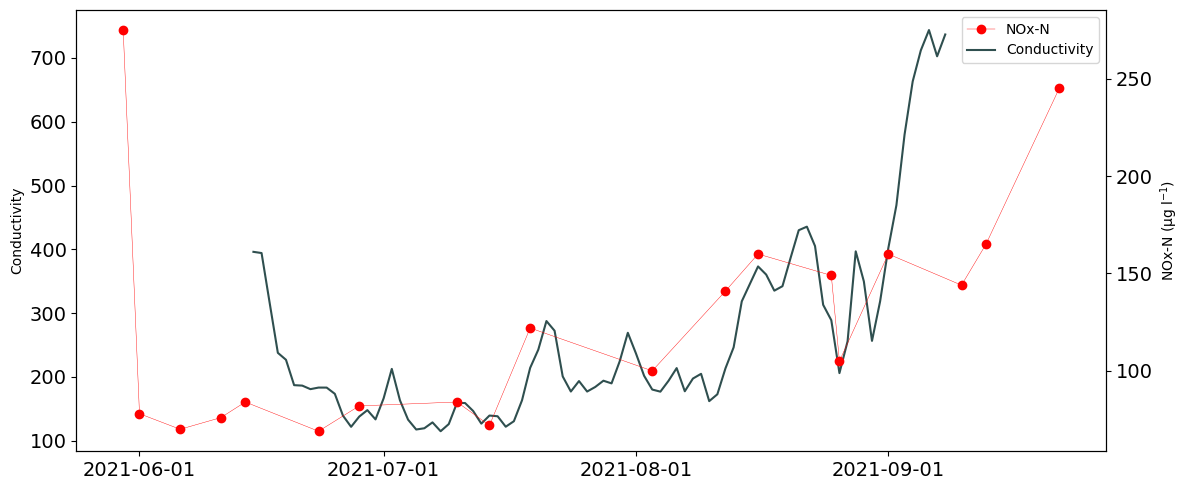

In [21]:
# test
plot_sensor_chem_ts(sensor_df, chem_df, 'Conductivity', ['NOx-N_ugL'], 2021, ts_folder)

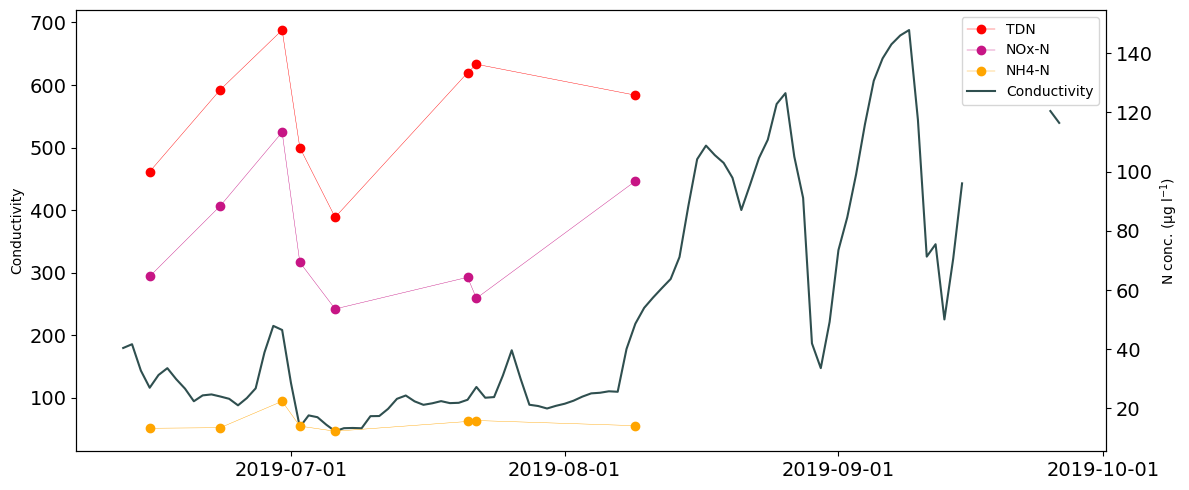

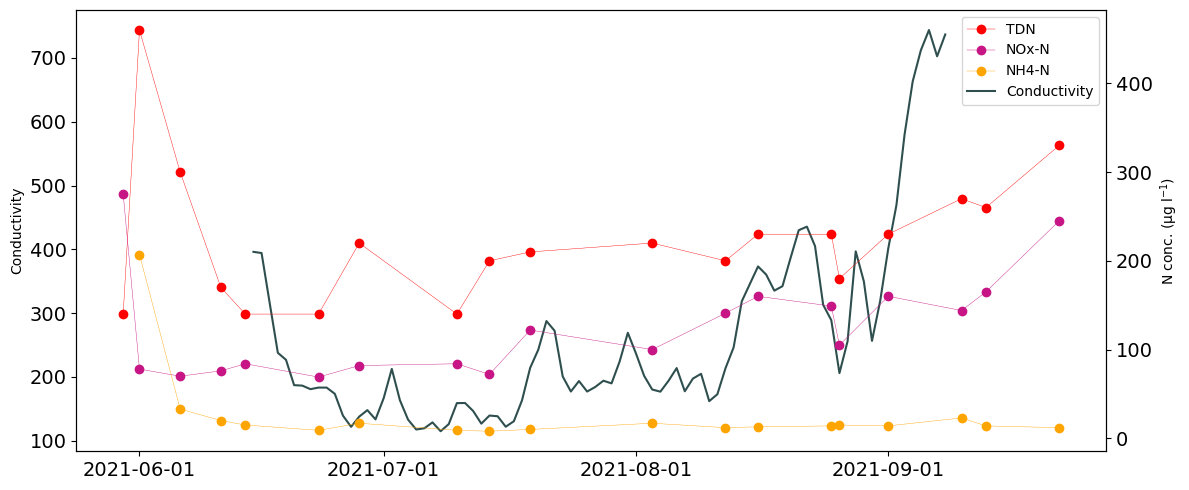

In [23]:
n_var_li = ["TDN_ugL", "NOx-N_ugL", "NH4-N_ugL"]
for sensor_var in ['Conductivity']:#, 'pH', 'Stage_norm', 'Turbidity']:
    for year in [2019, 2021]:
        plot_sensor_chem_ts(
            sensor_df,
            chem_df,
            sensor_var,
            n_var_li,
            year,
            ts_folder,
            y_label=r"N conc. ($\mu g \; l^{-1}$)",
            fname="N_species",
        )

# Look for regressions

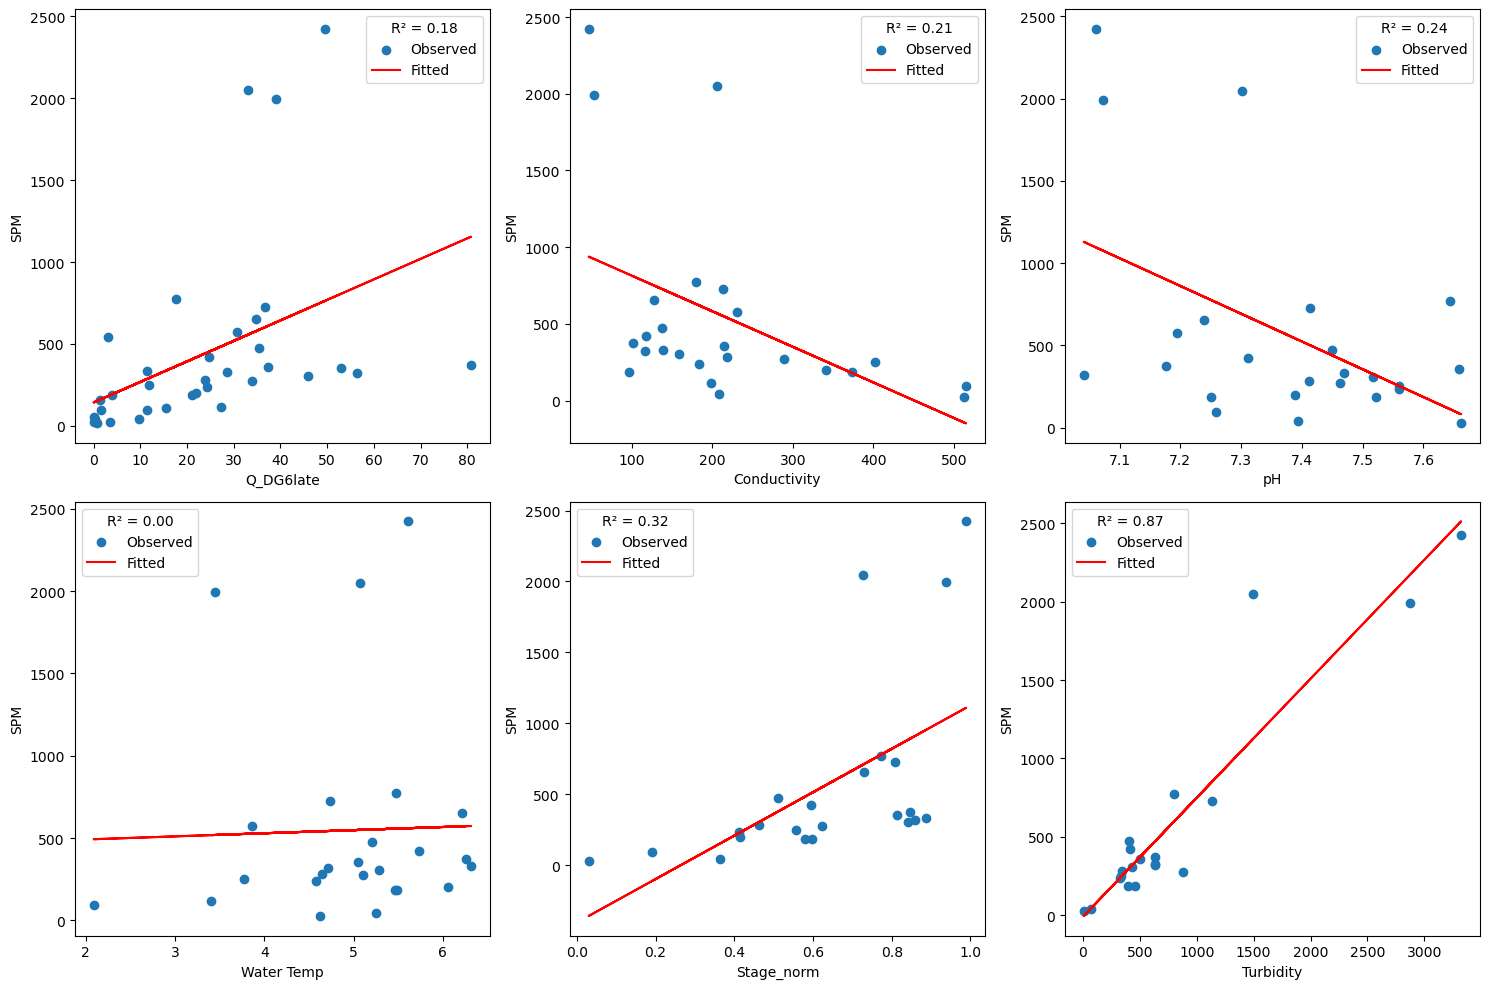

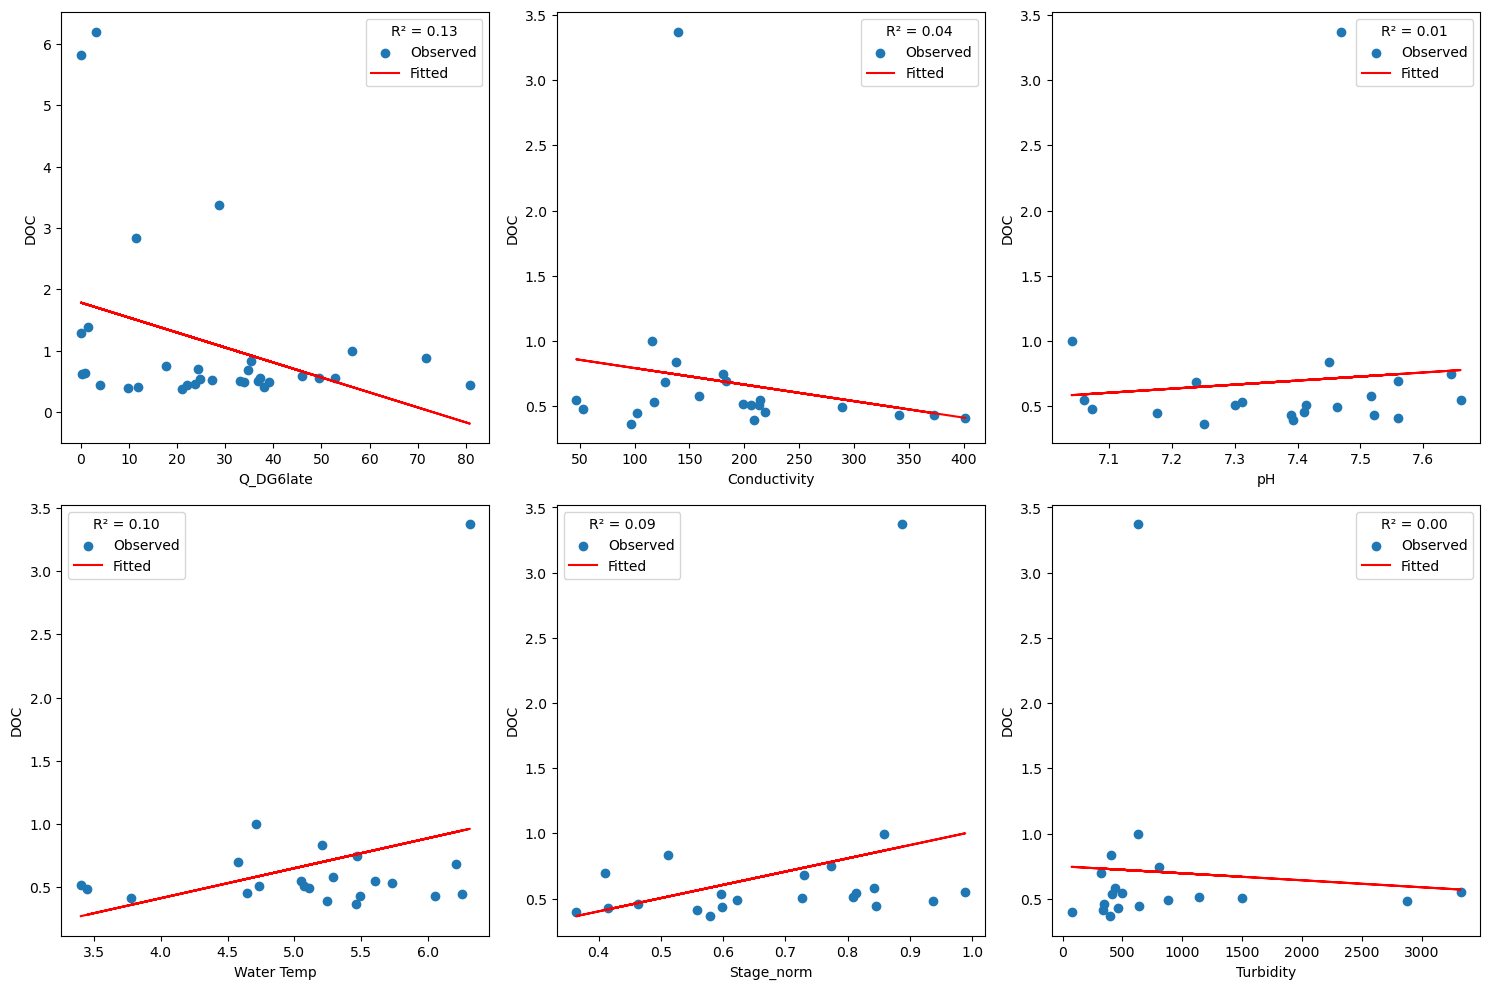

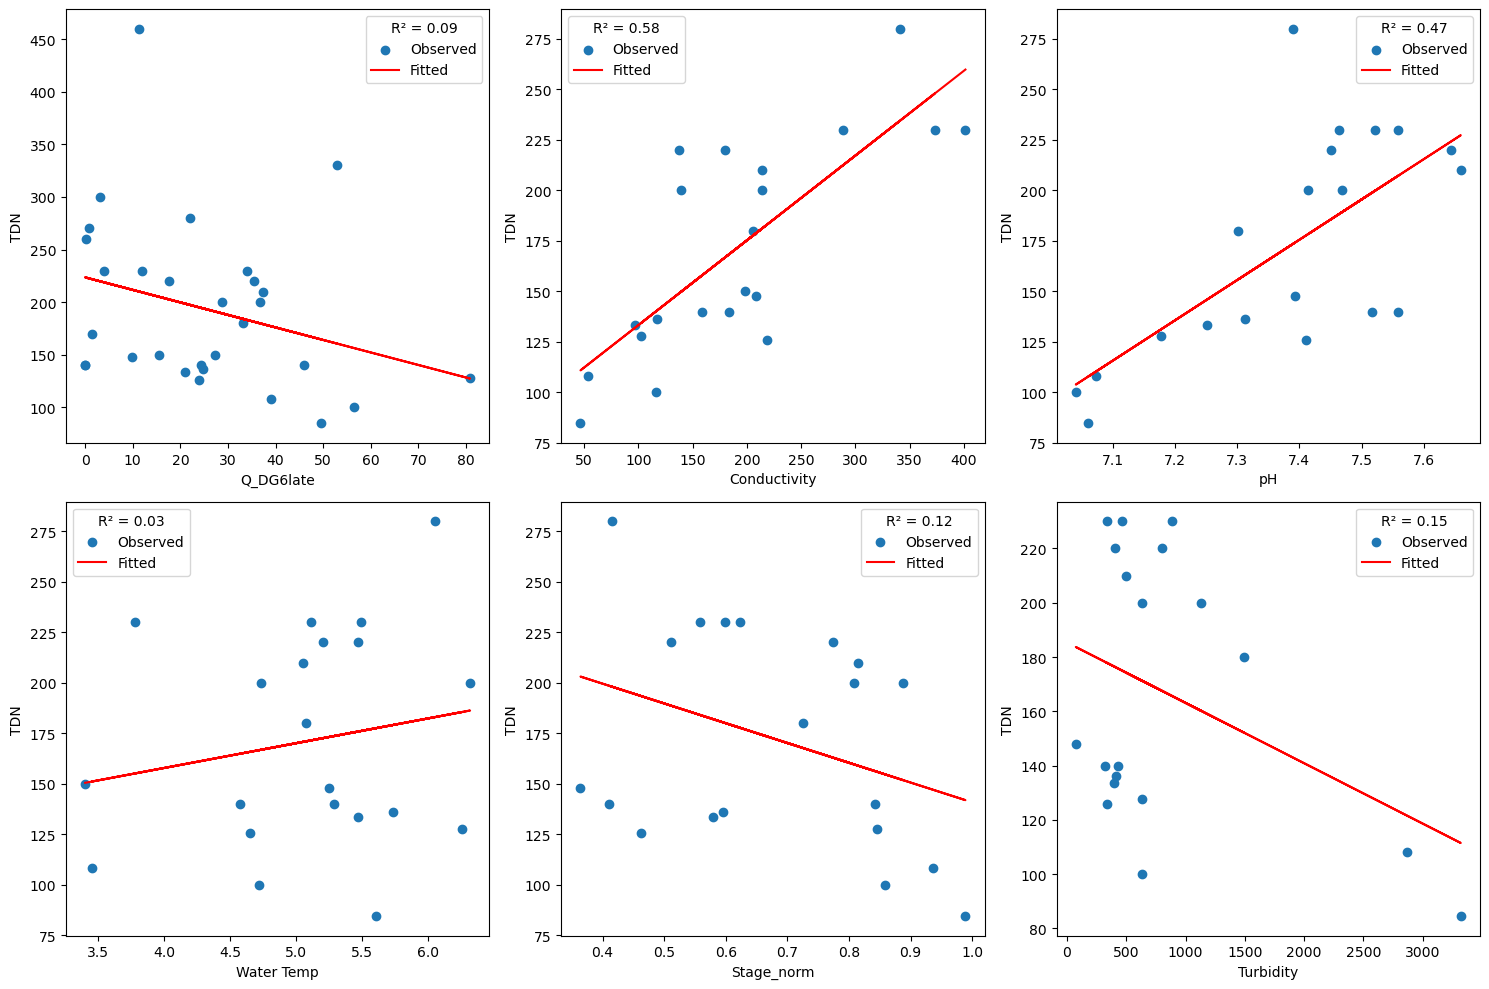

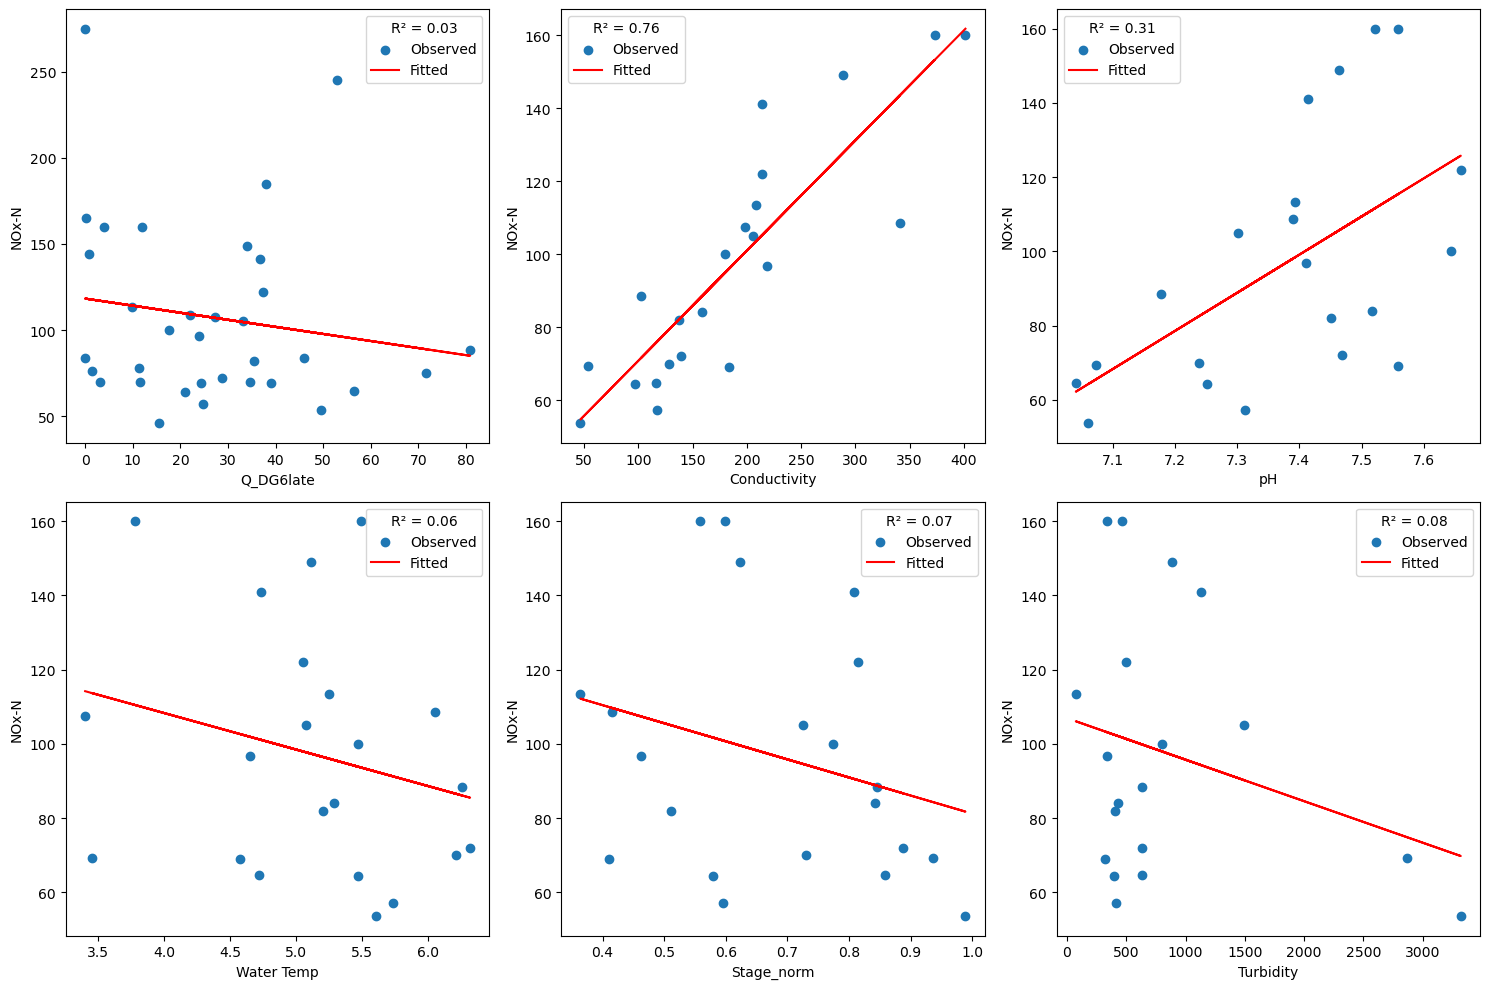

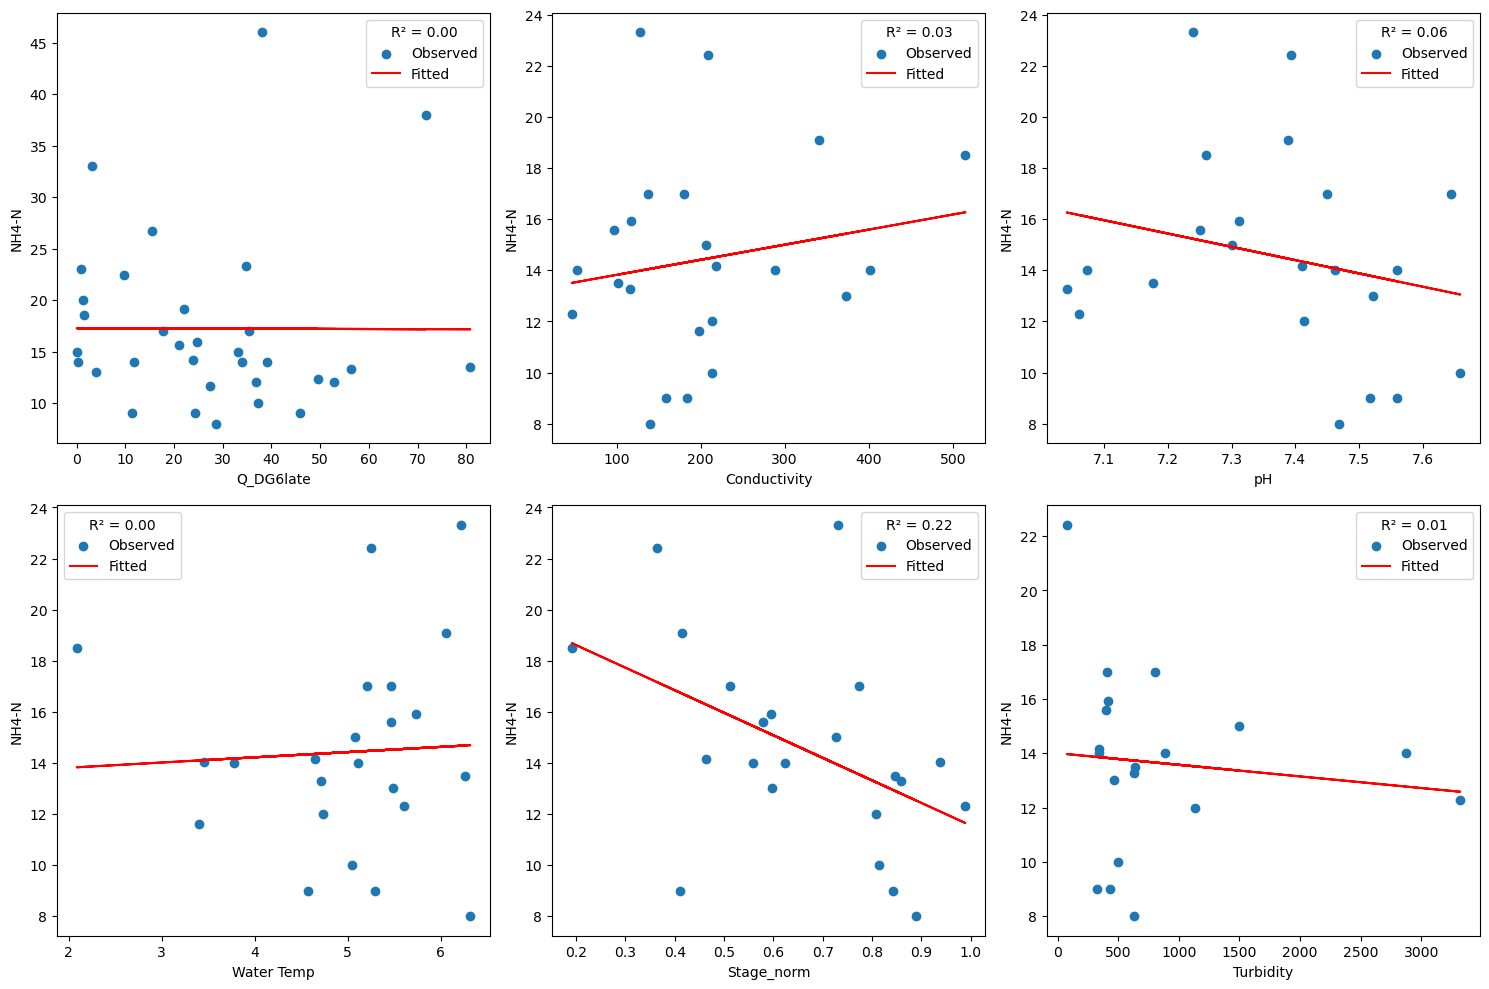

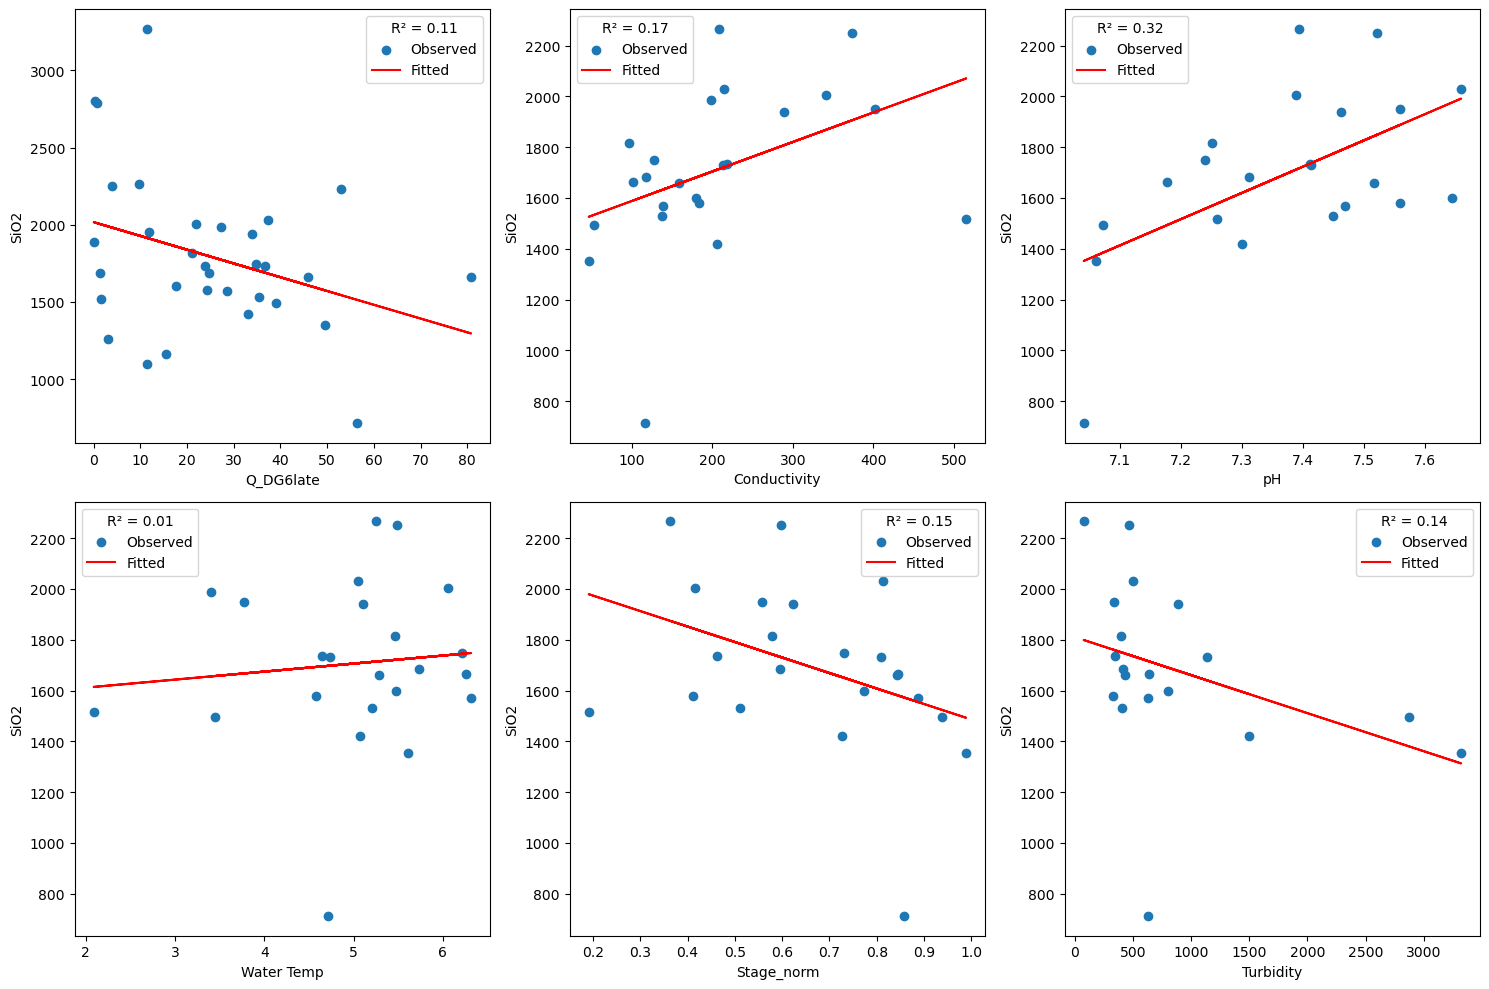

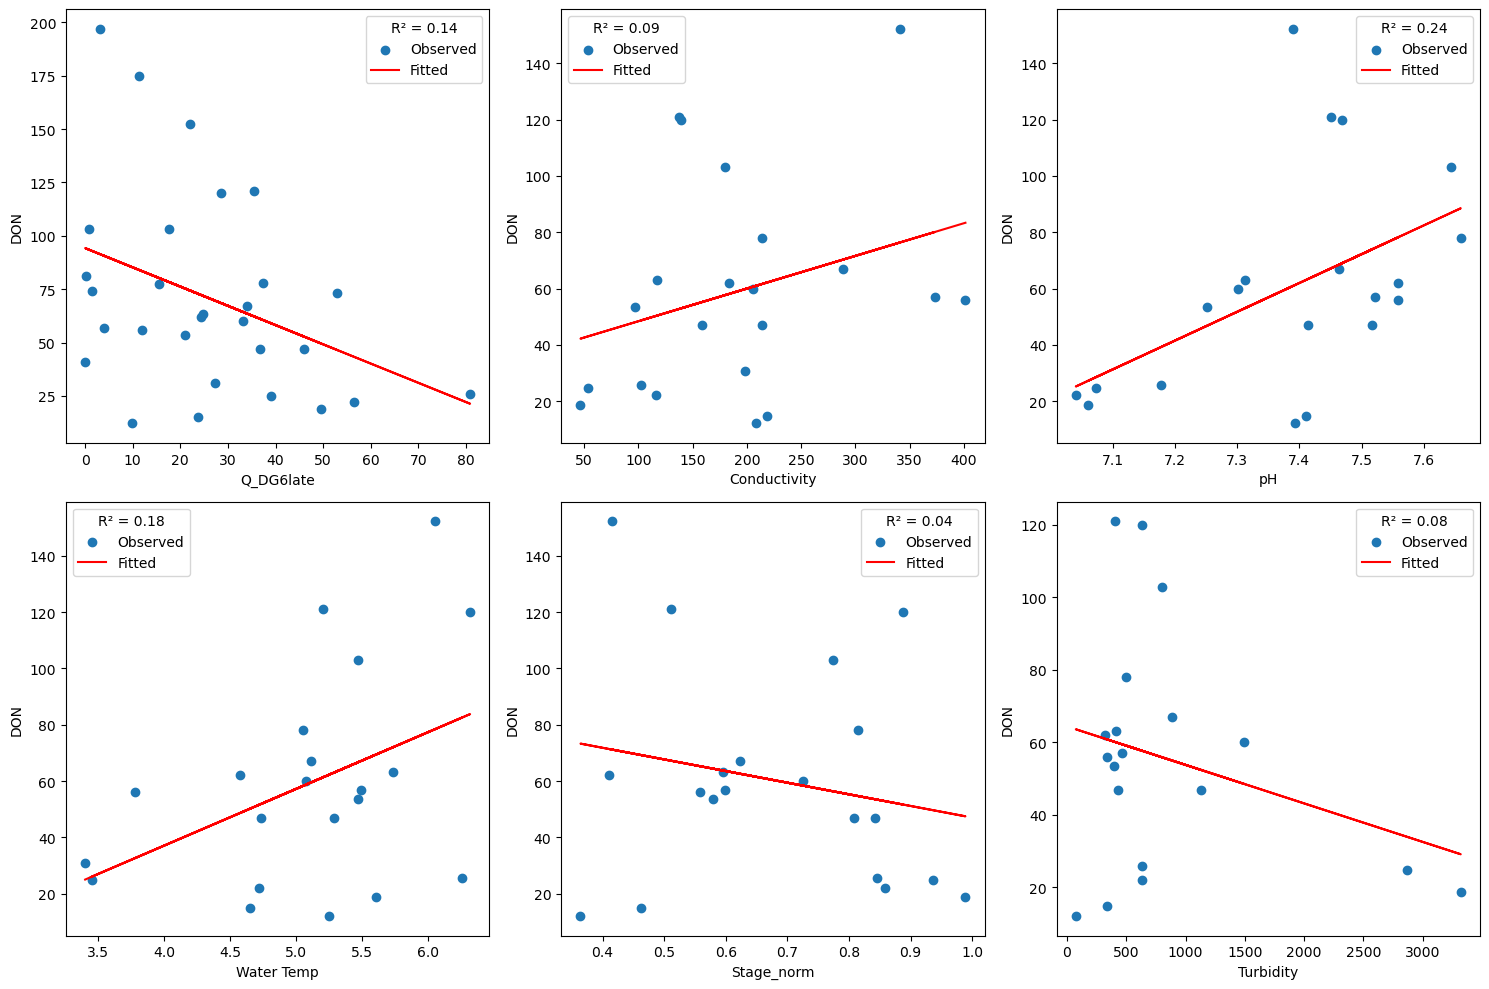

In [26]:
# Set up for plotting on a grid
n = len(x_df.columns)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

chem_df_regress = chem_df.copy()

model_r2_coeffs = {}

# Loop through each combination of columns
for chem_var in chem_df.columns:
# or just for select var, e.g.
# for chem_var in ['DOC_mgL', 'NOx-N_ugL', 'NH4-N_ugL', 'SiO2_ugL', 'SPM_mgL']:

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    axs = axs.flatten()

    for i, cont_var in enumerate(x_df.columns):
        # Join the data based on datetime index
        df = pd.concat([chem_df_regress[chem_var], x_df[cont_var]], axis=1, join='inner')
        df = df.dropna()

        # Fit a regression (start with a simple OLS regression)
        X = sm.add_constant(df[cont_var])  # independent variable
        y = df[chem_var]  # dependent variable

        model = sm.OLS(y, X)
        results = model.fit()

        chem_name = chem_var.split("_")[0]  # Drop the units

        # Save the r2 of the regression and the coefficients
        m, c = results.params[cont_var], results.params['const']
        model_r2_coeffs[(chem_name, cont_var)] = [results.rsquared, m, c]

        # If plotting a grid:

        # Plot a scatterplot of observed data together with the results of the regression model
        axs[i].scatter(df[cont_var], df[chem_var], label='Observed')
        axs[i].plot(df[cont_var], results.fittedvalues, color='red', label='Fitted')
        axs[i].set_xlabel(cont_var)
        axs[i].set_ylabel(chem_name)
        # axs[i].set_title(f'{chem_name} vs {cont_var}')

        # Add R-squared to the legend
        r2 = results.rsquared
        axs[i].legend(title=f'R² = {r2:.2f}')

    # Remove unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.savefig(f'../figures/waterchem-sensor-regressions/{chem_name}_drop_outlier.png')
    plt.show()

        # If just plotting a single figure, not a grid, uncomment this
        # plt.figure(figsize=(6, 4))
        # plt.scatter(df[cont_var], df[chem_var], label='Observed')
        # plt.plot(df[cont_var], results.fittedvalues, color='red', label='Fitted')
        # plt.xlabel(cont_var)
        # plt.ylabel(chem_name)
        # plt.title(f'{chem_name} vs {cont_var}')
        # plt.legend()
        # plt.savefig(f'../figures/waterchem-sensor-regressions/{chem_name}_v_{cont_var}.png')
        # plt.close()

In [27]:
# Convert r2 values and regression coefficients to a df and save

# Convert the dictionary to a DataFrame
regression_df = pd.DataFrame(
    [(k[0], k[1], v[0], v[1], v[2]) for k, v in model_r2_coeffs.items()],
    columns=["Chem_var", "Cont_var", "R2", "m", "c"],
)

regression_df.round(3).to_csv(r'../data/flux_calculations/chem-var_cont-var_regression_results_drop-outliers.csv')

# Show rows where R2 > 0.2

regression_df.loc[regression_df['R2'] >= 0.2].round(2)

,Chem_var,Cont_var,R2,m,c
1,SPM,Conductivity,0.21,-2.32,1046.93
2,SPM,pH,0.24,-1687.11,13008.55
4,SPM,Stage_norm,0.32,1530.50,-403.99
5,SPM,Turbidity,0.87,0.76,-9.28
13,TDN,Conductivity,0.58,0.42,91.24
14,TDN,pH,0.47,199.79,-1302.90
19,NOx-N,Conductivity,0.76,0.30,40.60
20,NOx-N,pH,0.31,102.94,-662.61
28,NH4-N,Stage_norm,0.22,-8.82,20.37
32,SiO2,pH,0.32,1034.61,-5932.93


# Linear regression with LOOCV to estimate prediction error

This needs merging with the above...

## Define function

Get an estimate of prediction error based on LOOCV: train the model on all data points except one and test the model on the single left-out observation. This process is then repeated for each data point in the dataset.

Which error metric is most appropriate? Derive MSE (absolute prediction error), as well as some relative error terms (e.g. MAPE and RSE)

In [39]:
# TODO handle cases when y_true = 0
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def ols_regression_loocv(y_df, y_var, x_df, x_var):
    """
    """
    df = pd.concat([y_df[y_var], x_df[x_var]], axis=1, join='inner')
    df = df.dropna()

    X = df[[x_var]]
    y = df[y_var]

    # Create a Linear Regression object
    regressor = LinearRegression()

    loo = LeaveOneOut()
    rmse_values = []
    mape_values = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model to the training data
        regressor.fit(X_train, y_train)

        # Use the model to predict on the test set
        y_pred = regressor.predict(X_test)

        # Calculate the error of the predictions
        mse = mean_squared_error(y_test, y_pred)
        rmse_values.append(np.sqrt(mse))

        mape = mean_absolute_percentage_error(y_test, y_pred)
        mape_values.append(mape)

    # Calculate average of MSE values for final estimate of error
    average_rmse = np.mean(rmse_values)
    average_mape = np.mean(mape_values)

    error_dict = {'rmse': np.round(average_rmse, 3),
                  'mape': np.round(average_mape)}

    return error_dict


# To incorporate, to plot predicted vs actual:

# regressor = LinearRegression()
# loo = LeaveOneOut()
# y_true = []
# y_pred = []

# for train_index, test_index in loo.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model to the training data
#     regressor.fit(X_train, y_train)

#     # Use the model to predict on the test set
#     prediction = regressor.predict(X_test)

#     y_true.append(y_test.values[0])
#     y_pred.append(prediction[0])

# # Create a scatter plot
# plt.scatter(y_true, y_pred)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Predicted vs Actual Values')

# # Plot a diagonal (this line represents y=x, where the predicted value equals the actual value)
# plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')

# plt.show()

In [40]:
# NOx vs conductivity
error_dict = ols_regression_loocv(chem_df_trimmed, 'NOx-N_ugL', sensor_df, 'Conductivity')
error_dict

{'rmse': 13.404, 'mape': 15.0}

## Seasonal split

For some variables, perhaps a seasonal split gives a better result (e.g. snowmelt vs rest of the yera). E.g. code here, needs adapting to the AquaInfra case (e.g. look at discharge time series and decide when the main snowmelt happens and tends to end by)

In [29]:
# Function to determine the season
def get_season(date):
    if date < pd.Timestamp(year=date.year, month=6, day=1):
        return 'melt'
    else:
        return 'rest_of_year'

# Add 'season' column to both dataframes (& check I haven't already called
# this cell!)
season_df = season_df.copy()
if 'season' not in season_df.columns:
    season_df['season'] = season_df.index.map(get_season)
if 'season' not in x_df.columns:
    x_df['season'] = x_df.index.map(get_season)

season_df.head()

,DOC,season
Date,,
2016-07-14,0.880,main_melt
2016-08-20,0.410,main_melt
2018-05-17,11.739,early_melt
2018-06-19,0.521,early_melt
2018-07-23,0.683,main_melt


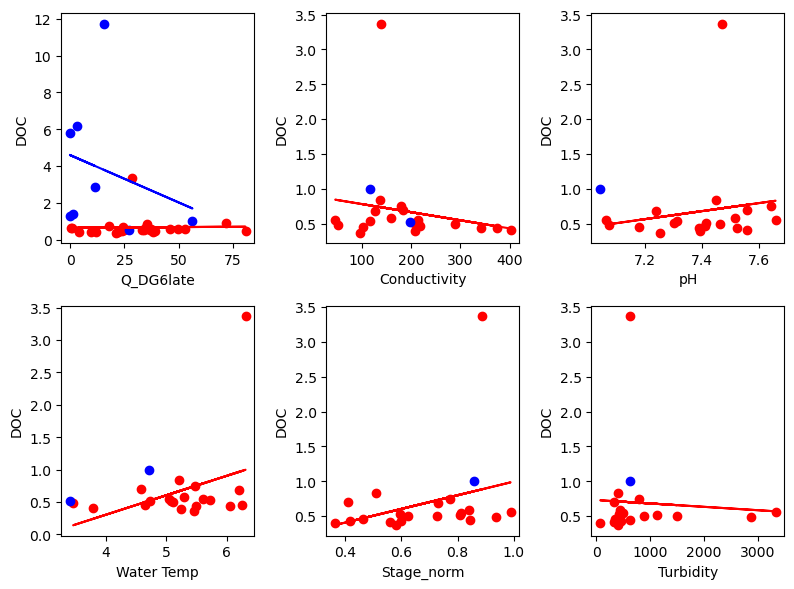

In [30]:
doc_season_model_result_dict = {}

# Define colors for each season
colors = {'melt': 'blue', 'rest_of_year': 'red'}

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 6))
axs = axs.flatten()
i = 0  # Counter for subplots

chem_var = 'DOC'

# Loop over unique seasons
for season in season_df['season'].unique():

    # Filter dataframes by season
    chem_df_season = season_df[season_df['season'] == season]
    x_df_season = x_df[x_df['season'] == season]

    for i, cont_var in enumerate(x_df_season.drop(columns='season').columns):

        df = pd.concat([chem_df_season[chem_var], x_df_season[cont_var]], axis=1, join='inner')
        df = df.dropna()

        # If df is empty, skip this iteration
        if df.empty:
            continue

        # Only do regression if have > 5 d.p.
        if len(df) > 5:

            # Fit a regression
            X = sm.add_constant(df[cont_var])  # independent variable
            y = df[chem_var]  # dependent variable

            model = sm.OLS(y, X)
            results = model.fit()

            m, c = results.params[cont_var], results.params['const']
            doc_season_model_result_dict[(season, cont_var)] = [results.rsquared, m, c]

            # Plot fitted model
            axs[i].plot(df[cont_var], results.fittedvalues, color=colors[season], label='Fitted')

        # Plot a scatterplot of observed data
        axs[i].scatter(df[cont_var], df[chem_var], color=colors[season], label='Observed')

        axs[i].set_xlabel(cont_var)
        axs[i].set_ylabel(chem_var)

        # Add R-squared to the legend
        # r2 = results.rsquared
        # axs[i].legend(title=f'R² = {r2:.2f}')

        i += 1

# Remove unused subplots
for j in range(i, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.savefig(f'../figures/waterchem-sensor-regressions/{chem_name}_drop_outlier.png')
plt.show()